In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln
from matplotlib.animation import FuncAnimation
%config InlineBackend.figure_format = 'retina'

Inspired to A statistical approach to the second law of thermodynamics using a computer simulation

L Bellomonte and R M Sperandeo-Mineo

Published under licence by IOP Publishing Ltd

European Journal of Physics, Volume 18, Number 5

DOI 10.1088/0143-0807/18/5/00

![Calculations](./images/calculations_second_law.jpeg)

In [36]:
class EnergyExchangeSystem:
    """
    A base class for a set of particles that could exchange energy. Subclasses must implement the step method.

    Parameters
        n (int): The number of particles
        random_state (None or int): The seed for the random number generator. If None,
            the random number generator is not seeded.
        initial_state (None or array): The initial state of the system. If None, a 
            random initial state is used.
        
    """
    def __init__(self, n, random_state=None, initial_energies=None):
        self.n = n
        self.random_state = random_state
        self.particles_id = np.arange(n)
        np.random.seed(self.random_state)

        ## The system is a 1D array of floats (=energy)
        if initial_energies is None:
            self.initial_energies = np.random.uniform(0., 1., self.n)
        else:
            self.initial_energies = initial_energies
        self.energies = self.initial_energies

        self.history = [self.energies]
    
    def step(self):
        """
        Execute a microscopic step
        """
        return NotImplementedError

    def simulate(self, n_steps):
        """
        Iterate the dynamics for n_steps, and return the results as an array
        """
        for i in range(n_steps):
            self.energies = self.step()
            self.history.append(self.energies)
    
    def energies_partitions(self, max_em, n_bins, ind=-1):
        """
        Calculates energies partitions:
        max_em is the max value of energy in units of mean energy
        n_bins in the number of partition bins
        Returns partition and bins coordinates
        """
        energy_partition, bins = np.histogram(self.history[ind]/np.mean(self.history[ind]), 
                                              range = (0, max_em), bins=n_bins, density=False)
        return energy_partition, bins

    def calculate_entropy(self, max_em, n_bins, ind=-1):
        """
        Calculates entropy of energy partition.
        max_em is the max value of energy in units of mean energy
        n_bins in the number of partition bins
        Returns entropy
        """
        energy_partition, _ = self.energies_partitions(max_em, n_bins, ind)
        return gammaln(self.n)-np.sum(gammaln(energy_partition[energy_partition>0]))
    
    def calculate_entropy_history(self, max_em, n_bins):
        """
        Calculates the history of entropy of energy partition.
        max_em is the max value of energy in units of mean energy
        n_bins in the number of partition bins
        Returns entropy history ndarray
        """
        entropy_history = np.zeros(len(self.history), dtype=np.float64)
        for i, es in enumerate(self.history):
            energy_partition, _ = np.histogram(es/np.mean(es), 
                                              range = (0, max_em), bins=n_bins, density=False)
            entropy_history[i] = gammaln(self.n)-np.sum(gammaln(energy_partition[energy_partition>0]))
        return entropy_history
    
    def get_particle_history(self, particle_id):
        """
        Returns the history of energy (in units of mean system energy) of a particle.
        particle_id is the id of the particle
        Returns energy history ndarray of the particle
        """
        particle_history = [h[particle_id]/np.mean(np.array(h)) for h in self.history]
        return np.array(particle_history)
        

In [37]:
class MaxwellBoltzmann(EnergyExchangeSystem):
    """
    Particles exchange kinetic energy as in a 3D gas of particles in d spatial dimensions
    """
    def __init__(self, d, n, **kwargs):
        super().__init__(n, **kwargs)
        self.d = d
    
    @staticmethod
    def p(x,d):
        return (x-x**2)**((d-2)/2)

    def step(self):
        """
        Output the next state:
        two random particles with kinetic energies e1 and e2 are chosen (e1+e2=etot)
        their new kinetic energies are sampled from the following probability distribution:
        P(e1) ~ sqrt(e1*(etot-e1)) and e2=etot-e1
        """
        p1, p2 = np.random.choice(self.particles_id, 2, replace=False)
        e_tot = self.energies[p1] + self.energies[p2]
        x = np.random.uniform(0., 1.)
        y = np.random.uniform(0., 0.5)
        while y>self.p(x, self.d):
            x = np.random.uniform(0., 1.)
            y = np.random.uniform(0., 0.5) 
        self.energies[p1] = x*e_tot
        self.energies[p2] = (1-x)*e_tot
        return self.energies.copy()
    
class RandomExchange(EnergyExchangeSystem):
    """
    Particles exchange kinetic energy randomly
    """
    def __init__(self, n, **kwargs):
        super().__init__(n, **kwargs)

    def step(self):
        """
        Output the next state:
        two random particles with kinetic energies e1 and e2 are chosen (e1+e2=etot)
        their new kinetic energies are sampled from the following probability distribution:
        P(e1) ~ uniform and e2=etot-e1
        """
        p1, p2 = np.random.choice(self.particles_id, 2, replace=False)
        e_tot = self.energies[p1] + self.energies[p2]
        x = np.random.uniform(0., 1.) 
        self.energies[p1] = x*e_tot
        self.energies[p2] = (1-x)*e_tot
        return self.energies.copy()

class ConstantExchange(EnergyExchangeSystem):
    """
    Particles exchange kinetic energy randomly
    """
    def __init__(self, n, rate, **kwargs):
        super().__init__(n, **kwargs)
        self.rate = rate
        
    def step(self):
        """
        Output the next state:
        two random particles with kinetic energies e1 and e2 are chosen (e1+e2=etot)
        their new kinetic energies are:
        e1 = rate*etot
        e2 = (1-rate)*etot
        """
        p1, p2 = np.random.choice(self.particles_id, 2, replace=False)
        e_tot = self.energies[p1] + self.energies[p2]
        self.energies[p1] = self.rate*e_tot
        self.energies[p2] = (1-self.rate)*e_tot
        return self.energies.copy()

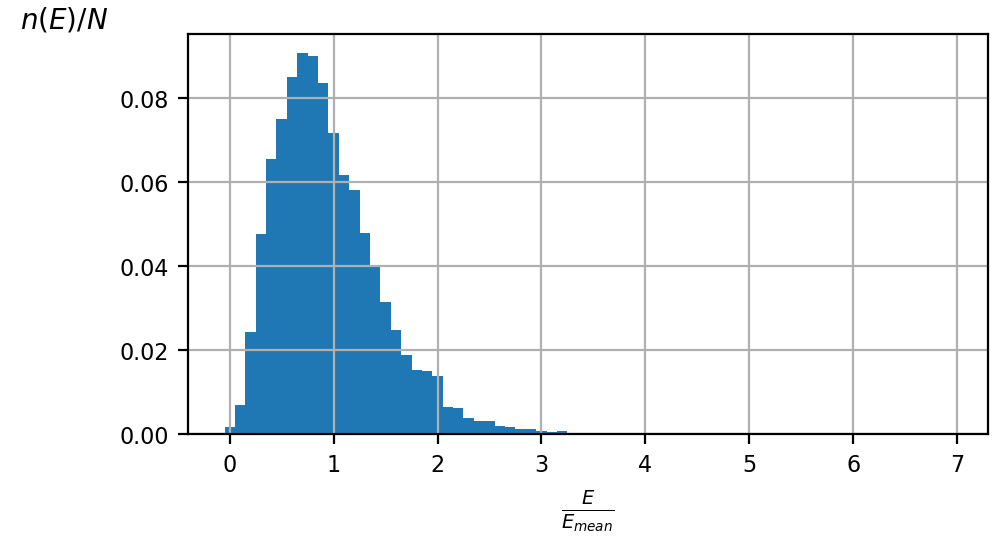

14739.934664489014


In [38]:
n_particles = 5000
model = MaxwellBoltzmann(8, n_particles, random_state=20)
model.simulate(20000)
max_em = 7
n_bins = 70

energy_partition, bins = model.energies_partitions(max_em, n_bins)
fig,ax = plt.subplots(figsize=(4,2))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.bar(bins[:-1], energy_partition/n_particles, width = max_em/n_bins)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel(r"$\frac{E}{E_{mean}}$")
ax.set_ylabel(r"$n(E)/N$", rotation="horizontal", loc="top", fontsize=10)
ax.grid()
plt.show()
print(model.calculate_entropy(7, 70))

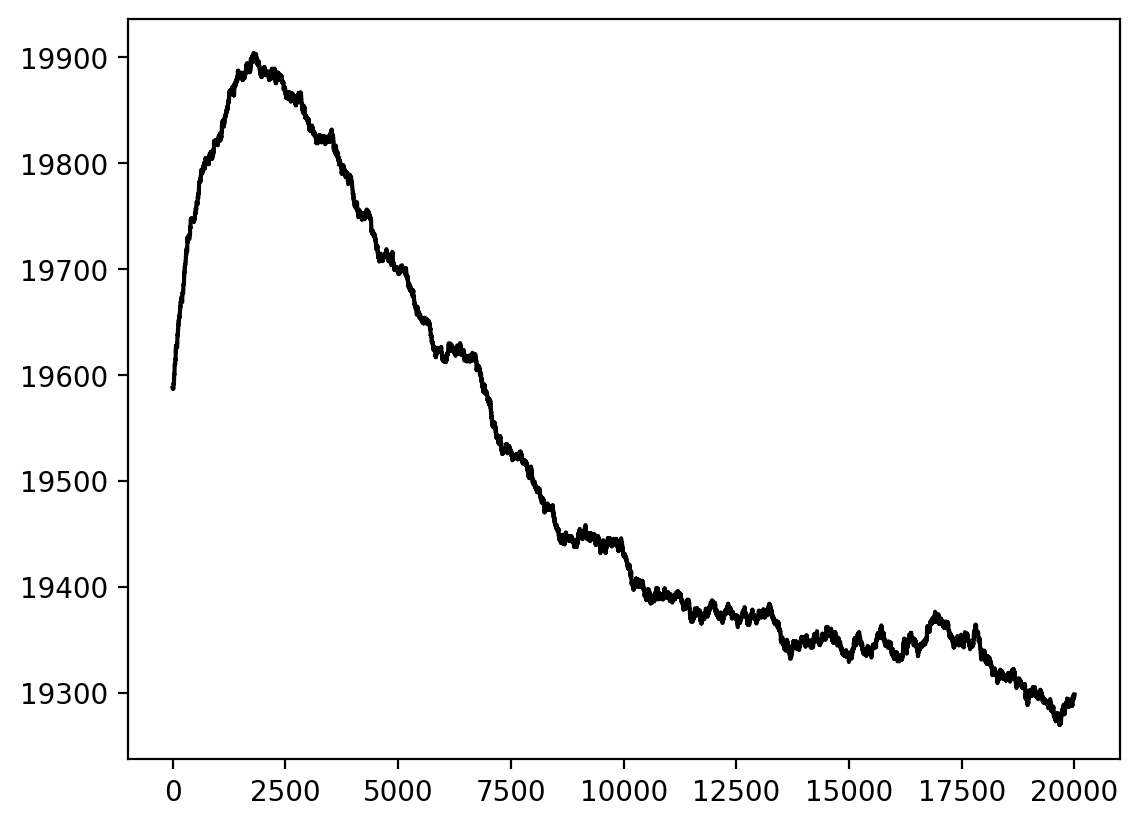

In [39]:
plt.plot(model.calculate_entropy_history(4, 100), color="k")

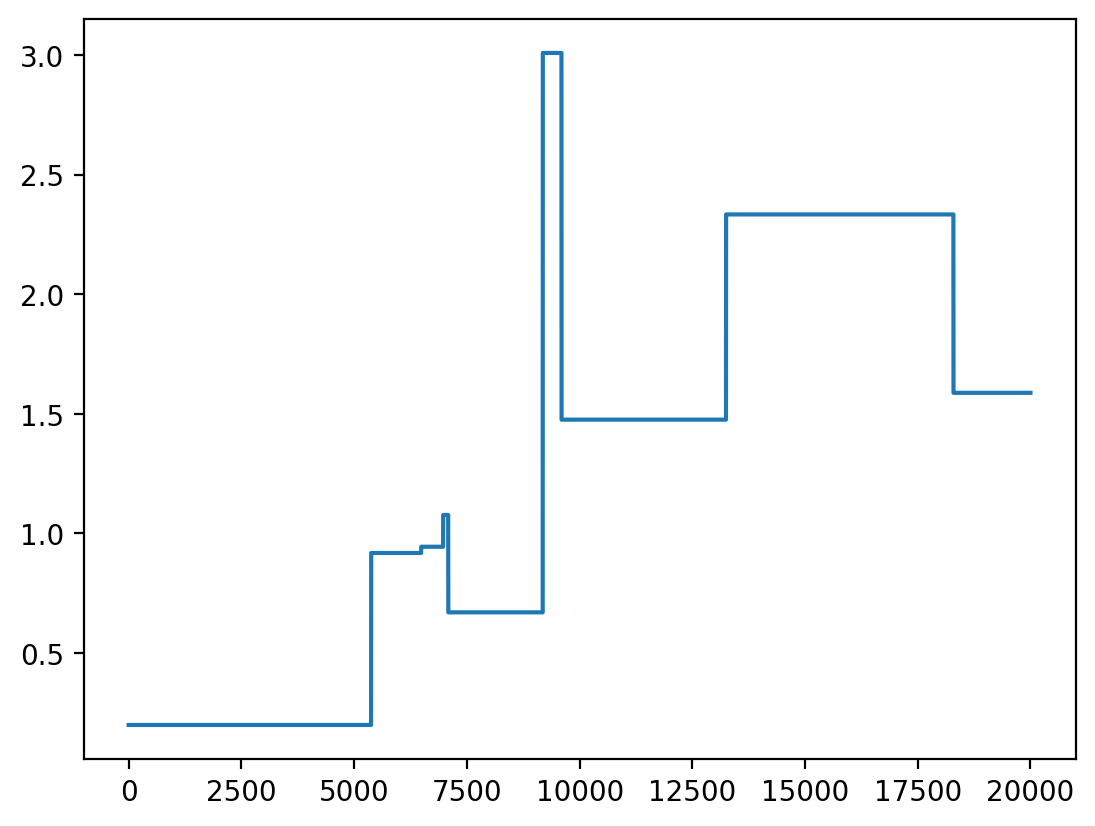

In [40]:
plt.plot(model.get_particle_history(2000))

## Make an interactive video

In [41]:
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    # plt.close()
    energy_partition, bins = energy_partition, bins = np.histogram(model.history[i]/np.mean(model.history[i]), range = (0, max_em), bins=n_bins, density=False)
    fig,ax = plt.subplots(figsize=(4,2))
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    ax.bar(bins[:-1], energy_partition/n_particles, width = max_em/n_bins)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlabel(r"$\frac{E}{E_{mean}}$")
    ax.set_ylabel(r"$n(E)/N$", rotation="horizontal", loc="top", fontsize=10)
    ax.grid()
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(model.history) - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=20000), Output()),…

<function __main__.plotter(i)>

## Shape of $p(x,d)$

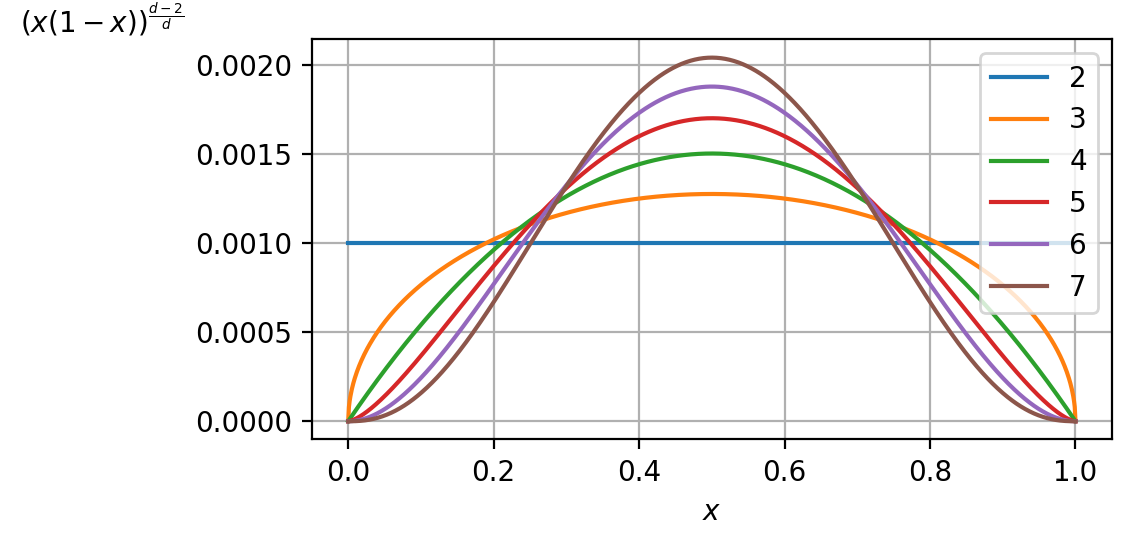

In [45]:
p = lambda x, d: (x-x**2)**((d-2)/2)
x = np.linspace(0., 1., 1000)
ds = list(range(2,8))
ys = [p(x,d)/np.sum(p(x,d)) for d in ds]
fig,ax = plt.subplots(figsize=(4,2))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
for d,y in zip(ds, ys):
    ax.plot(x,y, label=f"{d}")
ax.legend()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$(x(1-x))^{\frac{d-2}{d}}$", rotation="horizontal", loc="top", fontsize=10)
ax.grid()
plt.show()

## Animation

In [72]:
n_particles = 5000
model = MaxwellBoltzmann(3, n_particles, random_state=20, initial_energies=np.ones(n_particles))
nsteps = 20000
model.simulate(nsteps)

In [86]:
for i in range(0,nsteps,200):
    out_path = "./images.nosync/frame" + str(i).zfill(5) + ".png"
    max_em = 7
    n_bins = 70
    energy_partition, bins = model.energies_partitions(max_em, n_bins, ind=i)
    fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
    fig.set_facecolor("#f4f0e8")
    fig.suptitle(r"$p(x)\sim\sqrt{x-x^2}$")
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    axs[0].set_facecolor("#f4f0e8")
    axs[0].bar(bins[:-1], energy_partition/n_particles, width = max_em/n_bins, color="#383b3e")
    axs[0].tick_params(axis='both', which='major', labelsize=8)
    axs[0].set_xlabel(r"${E}/{E_{mean}}$", fontsize=15)
    axs[0].set_ylabel(r"$n(E)/N$", rotation="vertical", fontsize=15)
    #axs[0].set_ylim(0,0.09)
    #axs[0].grid()
    axs[1].set_facecolor("#f4f0e8")
    axs[1].plot(model.calculate_entropy_history(max_em, n_bins), color="#383b3e", linewidth=2)
    axs[1].scatter(i,model.calculate_entropy(max_em, n_bins, i), c="r", s=100)
    axs[1].set_xlabel("Simulation time", fontsize=15)
    axs[1].set_ylabel("Entropy", rotation="vertical", fontsize=15)
    #axs[1].grid()
    plt.savefig(out_path, bbox_inches="tight", pad_inches=0.5, dpi=300)
    plt.close() 
    #plt.show()